In [1]:
import os
import torch.nn as nn
import numpy as np
import torch
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from time import perf_counter
from IPython.display import clear_output, display

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device selected: {torch.cuda.get_device_name()}')

!pip install timm
import timm

Device selected: Tesla P100-PCIE-16GB


In [2]:
class delay(): # класс для подсчёта времени выполнения
    def __init__(self): 
        self.start = perf_counter()
    def start(self):
        self.start = perf_counter()
        return self
    def stop(self):
        self.end = perf_counter() - self.start; 
        mins = int(self.end // 60)
        secs = int(self.end % 60)
        print(f'Time taken:\t{mins}:{secs}')

def plot_stats(train_loss_accuracy, test_loss_accuracy, title = 'Model train'): # класс для рисования графиков ошибок
    fig = plt.figure(figsize = (8, 8))
    epoch = len(np.array(train_loss_accuracy)[:, 0])
    #plt.suptitle(f'{title}, epoch: {epoch}')
    plt.subplot(2, 1, 1) 
    plt.plot(range(1, epoch + 1), np.array(train_loss_accuracy)[:, 0], label = 'Train loss')
    plt.plot(range(1, epoch + 1), np.array(test_loss_accuracy)[:, 0], label = 'Test loss')
    plt.ylabel('Loss')
    plt.legend(); plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(range(1, epoch + 1), np.array(train_loss_accuracy)[:, 1], label = 'Train accuracy')
    plt.plot(range(1, epoch + 1), np.array(test_loss_accuracy)[:, 1], label = 'Test accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid();
    
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

In [3]:
def model_train(loader, model, loss_fn, optimizer, epoch):
    model.to(device)
    model.train() # Переводим модель в режим обучения
    tLoss, tTotal, tCorrect = 0, 0, 0 # Инициализируем метрики
    
    for x, y in tqdm(loader, desc = f'Train {epoch+1}'):
        
        x, y = x.to(device), y.to(device) # Перемещаем всё на GPU
        
        optimizer.zero_grad() # Forward pass: Обнуляем градиенты, проходим вперёд и считаем loss
        forward = model(x)
        loss = loss_fn(forward, y)
        
        tLoss += loss.item() # Подсчитываем loss и accuracy на трейне
        _, y_pred = torch.max(forward, 1)
        tTotal += y.size(0)
        tCorrect += (y_pred == y).sum().item()
        
        loss.backward() # Backward pass: вычитаем градиенты и делаем шаг оптимизации
        optimizer.step()
        
    tLoss /= len(loader) # Считаем loss на трейне 
    tAccuracy = tCorrect / tTotal # считаем accuracy на трейне 
    return tLoss, tAccuracy
    
def model_eval(loader, model, loss_fn):
    model.to(device)
    model.eval() # Переводим модель в режим валидации
    tLoss, tTotal, tCorrect = 0, 0, 0
    
    for x, y in tqdm(loader, desc = 'Eval '):
        with torch.no_grad(): # Выключаем подсчёт градиентов в контексте
    
            x, y = x.to(device), y.to(device) # перемещаем всё на GPU

            forward = model(x) # Forward pass: проход вперёд и подсчёт loss'a
            loss = loss_fn(forward, y)
            
            tLoss += loss.item() # Подсчёт метрик 50%
            _, y_pred = torch.max(forward, 1)
            tTotal += y.size(0)
            tCorrect += (y_pred == y).sum().item()
            
    tLoss /= len(loader) # Подсчёт метрик 100%
    tAccuracy = tCorrect / tTotal
    return tLoss, tAccuracy

In [4]:
class model_three(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(p = 0.2),
        
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(p = 0.2),
        
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(p = 0.2),
            
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(p = 0.2),
            
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(p = 0.2),
            
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.Dropout1d(p = 0.3),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.net(x)

In [5]:
def octava(model, train_loader, test_loader, epochs = 25, title = ''): # Полный цикл обучения
    train_loss_accuracy, test_loss_accuracy = [], []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    scheduler = StepLR(optimizer, step_size = 25)
    d = delay()
    for e in range(epochs):
        train_loss_accuracy += [model_train(train_loader, model, loss_fn, optimizer, e)]
        test_loss_accuracy += [model_eval(test_loader, model, loss_fn)]
        
        plot_stats(train_loss_accuracy, test_loss_accuracy, title = title)
        scheduler.step()
    d.stop()

In [6]:
dataset_train = CIFAR10('./datasets/cifar10', train=True, transform=T.ToTensor(), download = True)
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

trans_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])
trans_train = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomResizedCrop(size = 32, scale = (0.8, 1.1)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    trans_test,
])

test_loader = DataLoader(CIFAR10('./datasets/cifar10', False, trans_test, download = True), 50, num_workers = 4, pin_memory = True)
train_loader = DataLoader(CIFAR10('./datasets/cifar10', True, trans_train, download = True), 50, num_workers = 4, pin_memory = True)

100%|██████████| 170498071/170498071 [00:02<00:00, 58103816.60it/s]


Extracting ./datasets/cifar10/cifar-10-python.tar.gz to ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = model_three()
#octava(model, train_loader, test_loader, 100, 'Batch norm + Dropout + Scheduler')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny

class ConvNeXtCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNeXtCIFAR10, self).__init__()
        # Загружаем предобученную модель ConvNeXt Tiny и адаптируем её под 10 классов
        self.model = convnext_tiny(weights='DEFAULT')
        self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ConvNeXtCIFAR10().to(device)
#di = octava(model, train_loader, test_loader, 15, 'ConvNeXt')

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 60.5MB/s] 


In [9]:
def model_predict(model, test_loader):
    model.to(device)
    model.eval()
    for x, y in tqdm(loader, desc = 'Prediction'):
        with torch.no_grad(): 
            x, y = x.to(device), y.to(device)
            forward = model(x)
            _, y_pred = torch.max(forward, 1)
    return y_pred

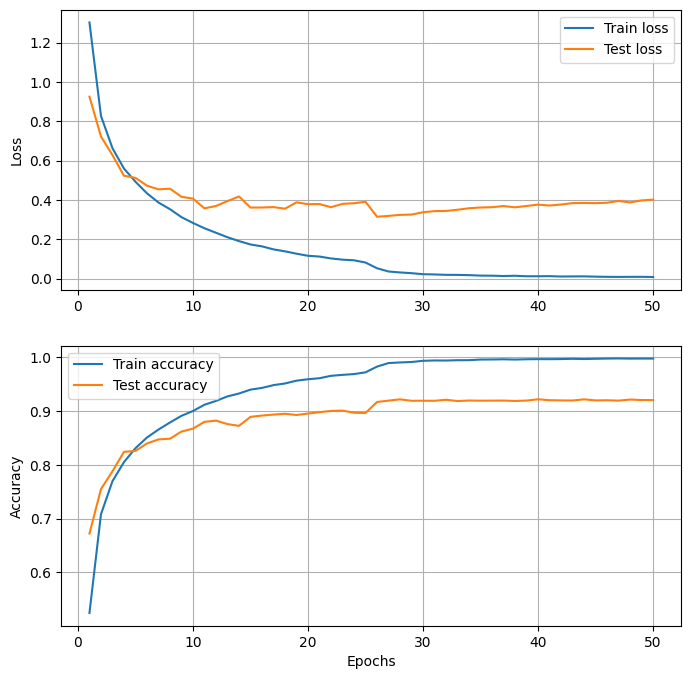

Time taken:	28:52


In [10]:
from torchvision.models.resnet import ResNet, BasicBlock
class XResNet(ResNet):
    def __init__(self, block, layers, num_classes=10):
        super(XResNet, self).__init__(block, layers, num_classes=num_classes)
        self.inplanes = 64
        # Обновлённый конструктор для правильного количества каналов
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # Убираем maxpooling для адаптации под размер входа

        # Переопределяем классификатор
        self.fc = nn.Linear(512 * block.expansion, num_classes)

def xresnet18(num_classes=10):
    return XResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

model_xres = xresnet18()
octava(model_xres, train_loader, test_loader, 50, 'xresnet18')